## Final Project 
### Blindness Detection
#### Group: Gareth Sun zs389, Zimu Li zl898, Arman Syed as3778


### 1. Data Preprocess

In [14]:
# Import the Library we need
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import torch
import matplotlib.pyplot as plt

In [15]:
print(torch.__version__)
print(torch.cuda.is_available())

2.1.1
True


In [16]:
cuda_available = torch.cuda.is_available()
device = torch.device("cuda" if cuda_available else "cpu")
print(device)

cuda


In [17]:
print(tf.config.list_physical_devices('GPU'))

[]


In [18]:
# Load training Data
train_df = pd.read_csv('train.csv')
train_df['diagnosis'] = train_df['diagnosis'].astype(str)
train_df['pic_id'] = train_df['id_code'].astype(str)+'.png'
train_df.head()

,id_code,diagnosis,pic_id
0,000c1434d8d7,2,000c1434d8d7.png
1,001639a390f0,4,001639a390f0.png
2,0024cdab0c1e,1,0024cdab0c1e.png
3,002c21358ce6,0,002c21358ce6.png
4,005b95c28852,0,005b95c28852.png


In [19]:
# Data Load
preprocessor = ImageDataGenerator(
    # Normalization
    rescale=1/255,
    validation_split=0.2
)

# Set the batch and image size
image_size = 64
batch_size = 32

train_pic = preprocessor.flow_from_dataframe(
    dataframe=train_df,
    directory='train_images',
    x_col='pic_id',
    y_col='diagnosis',
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    subset='training',
    target_size=(image_size, image_size)
)

test_pic = preprocessor.flow_from_dataframe(
    dataframe=train_df,
    directory='train_images',
    x_col='pic_id',
    y_col='diagnosis',
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    subset='validation',
    target_size=(image_size, image_size)
)

# Covert category into one-hot code
train_label = pd.get_dummies(train_df['diagnosis'])
num_classes = train_label.shape[1]
num_samples = train_label.shape[0]

print(num_classes)
print(num_samples)


Found 2930 validated image filenames belonging to 5 classes.


Found 732 validated image filenames belonging to 5 classes.
5
3662


### 2. Build CNN Model

In [28]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GaussianDropout
from keras.constraints import MaxNorm
from keras import regularizers

In [30]:
def cnn_model(image_size, num_classes):
    model = Sequential()

    model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(image_size, image_size, 3)))
    model.add(GaussianDropout(0.3))
    model.add(Conv2D(32, (5, 5), activation='relu', kernel_constraint=MaxNorm(3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (5, 5), activation='relu'))
    model.add(Conv2D(64, (7, 7), activation='relu'))
    
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))

    model.add(Dense(num_classes, activation='softmax', kernel_regularizer=regularizers.l2(0.0001)
                   ,activity_regularizer=regularizers.l1(0.01)))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [31]:
model = cnn_model(image_size, num_classes)
# Save the model
from keras.callbacks import ModelCheckpoint
from keras.callbacks import Callback

tm = ModelCheckpoint('version1', monitor='val_loss', save_best_only = True, mode ='min', verbose = 1)

class AccuracyPlotter(Callback):
    def on_train_begin(self, logs={}):
        self.train_acc = []
        self.val_acc = []

    def on_epoch_end(self, epoch, logs={}):
        self.train_acc.append(logs.get('accuracy'))
        self.val_acc.append(logs.get('val_accuracy'))

    def on_train_end(self, logs={}):
        plt.figure(figsize=(20,10))
        plt.plot(range(1, len(self.train_acc) + 1), self.train_acc, label='Training Accuracy')
        plt.plot(range(1, len(self.val_acc) + 1), self.val_acc, label='Validation Accuracy')
        plt.title('Accuracy Plot')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.xticks(range(1, len(self.train_acc) + 1))
        plt.legend()
        plt.grid(True)
        plt.show()
        
plotter = AccuracyPlotter()

Epoch 1/50

91/91 [==============================] - ETA: 0s - loss: 2.4668 - accuracy: 0.4931
Epoch 1: val_loss improved from inf to 1.36298, saving model to version1
INFO:tensorflow:Assets written to: version1\assets


INFO:tensorflow:Assets written to: version1\assets


91/91 [==============================] - 217s 2s/step - loss: 2.4668 - accuracy: 0.4931 - val_loss: 1.3630 - val_accuracy: 0.4645
Epoch 2/50
91/91 [==============================] - ETA: 0s - loss: 1.0442 - accuracy: 0.6912
Epoch 2: val_loss improved from 1.36298 to 0.94854, saving model to version1
INFO:tensorflow:Assets written to: version1\assets


INFO:tensorflow:Assets written to: version1\assets


91/91 [==============================] - 173s 2s/step - loss: 1.0442 - accuracy: 0.6912 - val_loss: 0.9485 - val_accuracy: 0.6932
Epoch 3/50
91/91 [==============================] - ETA: 0s - loss: 0.9275 - accuracy: 0.7036
Epoch 3: val_loss improved from 0.94854 to 0.90323, saving model to version1
INFO:tensorflow:Assets written to: version1\assets


INFO:tensorflow:Assets written to: version1\assets


91/91 [==============================] - 172s 2s/step - loss: 0.9275 - accuracy: 0.7036 - val_loss: 0.9032 - val_accuracy: 0.6761
Epoch 4/50
91/91 [==============================] - ETA: 0s - loss: 0.8377 - accuracy: 0.7174
Epoch 4: val_loss improved from 0.90323 to 0.83473, saving model to version1
INFO:tensorflow:Assets written to: version1\assets


INFO:tensorflow:Assets written to: version1\assets


91/91 [==============================] - 184s 2s/step - loss: 0.8377 - accuracy: 0.7174 - val_loss: 0.8347 - val_accuracy: 0.7131
Epoch 5/50
91/91 [==============================] - ETA: 0s - loss: 0.8033 - accuracy: 0.7229
Epoch 5: val_loss improved from 0.83473 to 0.81544, saving model to version1
INFO:tensorflow:Assets written to: version1\assets


INFO:tensorflow:Assets written to: version1\assets


91/91 [==============================] - 189s 2s/step - loss: 0.8033 - accuracy: 0.7229 - val_loss: 0.8154 - val_accuracy: 0.7145
Epoch 6/50
91/91 [==============================] - ETA: 0s - loss: 0.7986 - accuracy: 0.7246
Epoch 6: val_loss did not improve from 0.81544
91/91 [==============================] - 176s 2s/step - loss: 0.7986 - accuracy: 0.7246 - val_loss: 0.8308 - val_accuracy: 0.6889
Epoch 7/50
91/91 [==============================] - ETA: 0s - loss: 0.7907 - accuracy: 0.7215
Epoch 7: val_loss improved from 0.81544 to 0.80565, saving model to version1
INFO:tensorflow:Assets written to: version1\assets


INFO:tensorflow:Assets written to: version1\assets


91/91 [==============================] - 178s 2s/step - loss: 0.7907 - accuracy: 0.7215 - val_loss: 0.8057 - val_accuracy: 0.7074
Epoch 8/50
91/91 [==============================] - ETA: 0s - loss: 0.7768 - accuracy: 0.7264
Epoch 8: val_loss improved from 0.80565 to 0.77468, saving model to version1
INFO:tensorflow:Assets written to: version1\assets


INFO:tensorflow:Assets written to: version1\assets


91/91 [==============================] - 178s 2s/step - loss: 0.7768 - accuracy: 0.7264 - val_loss: 0.7747 - val_accuracy: 0.7173
Epoch 9/50
91/91 [==============================] - ETA: 0s - loss: 0.7748 - accuracy: 0.7277
Epoch 9: val_loss did not improve from 0.77468
91/91 [==============================] - 171s 2s/step - loss: 0.7748 - accuracy: 0.7277 - val_loss: 0.7834 - val_accuracy: 0.7202
Epoch 10/50
91/91 [==============================] - ETA: 0s - loss: 0.7763 - accuracy: 0.7371
Epoch 10: val_loss did not improve from 0.77468
91/91 [==============================] - 171s 2s/step - loss: 0.7763 - accuracy: 0.7371 - val_loss: 0.8297 - val_accuracy: 0.6946
Epoch 11/50
91/91 [==============================] - ETA: 0s - loss: 0.7920 - accuracy: 0.7246
Epoch 11: val_loss did not improve from 0.77468
91/91 [==============================] - 171s 2s/step - loss: 0.7920 - accuracy: 0.7246 - val_loss: 0.7832 - val_accuracy: 0.7116
Epoch 12/50
91/91 [==============================] - 

INFO:tensorflow:Assets written to: version1\assets


91/91 [==============================] - 172s 2s/step - loss: 0.7728 - accuracy: 0.7257 - val_loss: 0.7540 - val_accuracy: 0.7216
Epoch 13/50
91/91 [==============================] - ETA: 0s - loss: 0.7592 - accuracy: 0.7326
Epoch 13: val_loss did not improve from 0.75404
91/91 [==============================] - 171s 2s/step - loss: 0.7592 - accuracy: 0.7326 - val_loss: 0.7659 - val_accuracy: 0.7188
Epoch 14/50
91/91 [==============================] - ETA: 0s - loss: 0.7701 - accuracy: 0.7277
Epoch 14: val_loss did not improve from 0.75404
91/91 [==============================] - 170s 2s/step - loss: 0.7701 - accuracy: 0.7277 - val_loss: 0.7802 - val_accuracy: 0.7202
Epoch 15/50
91/91 [==============================] - ETA: 0s - loss: 0.7571 - accuracy: 0.7350
Epoch 15: val_loss did not improve from 0.75404
91/91 [==============================] - 170s 2s/step - loss: 0.7571 - accuracy: 0.7350 - val_loss: 0.7568 - val_accuracy: 0.7315
Epoch 16/50
91/91 [==============================] 

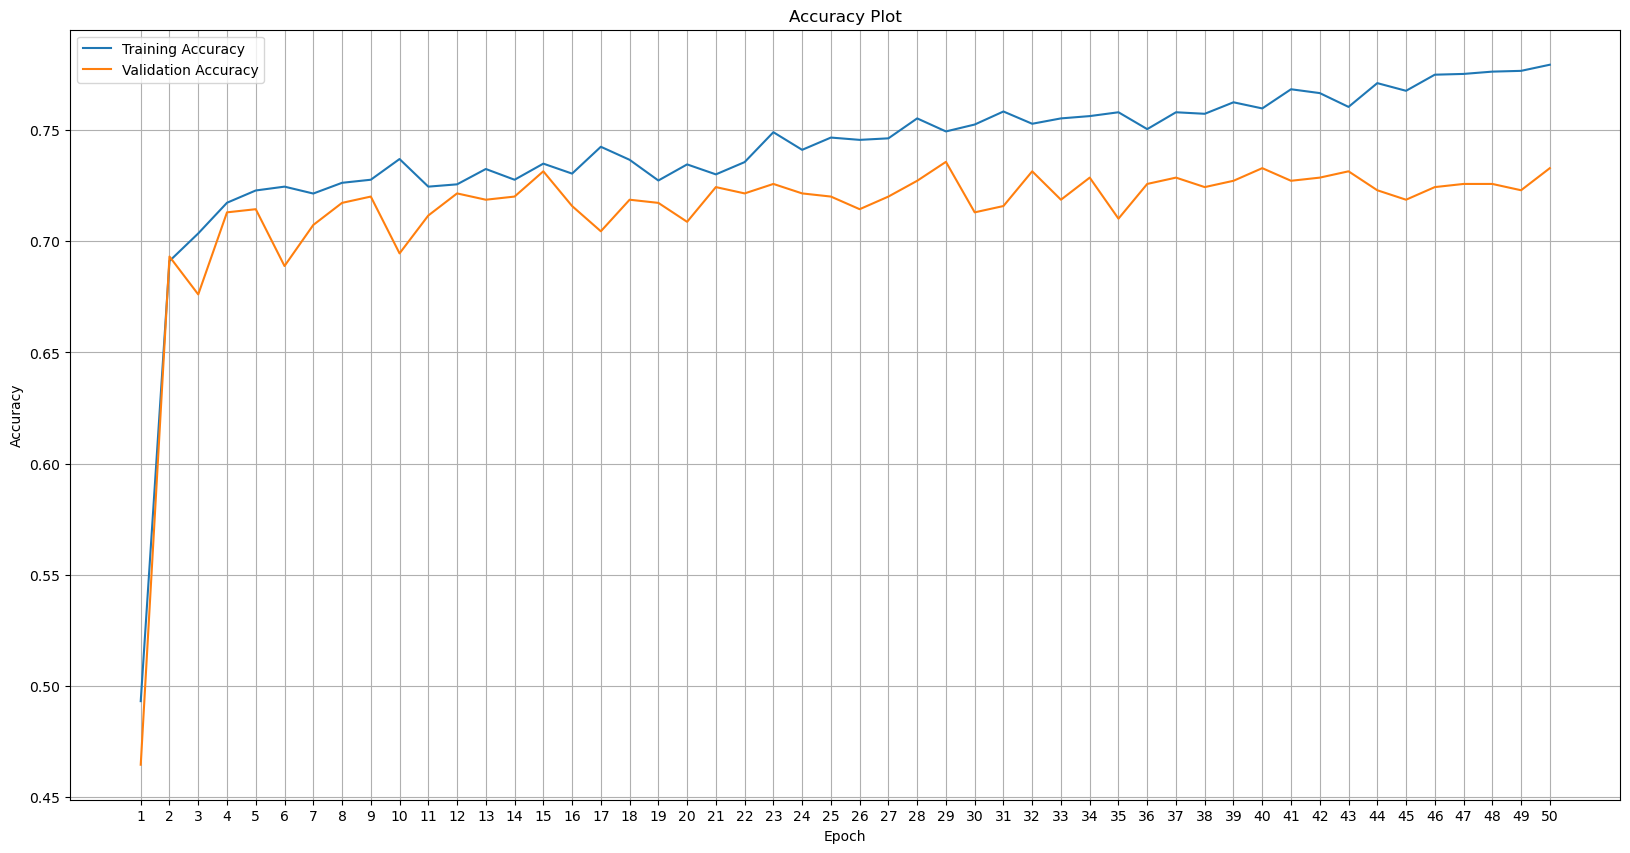

In [32]:
steps_per_epoch = 2930 // batch_size
validation_steps = 732 // batch_size
model.fit(
    train_pic,
    steps_per_epoch=steps_per_epoch, 
    epochs=50, 
    validation_data=test_pic,
    validation_steps=validation_steps,
    callbacks=[tm, plotter]
)

### 3. Give out Prediction Results

In [33]:
from keras.models import load_model
from math import ceil

trained_model = load_model('version1')

prediction_df = pd.read_csv('sample_submission.csv')
prediction_df['pic_id'] = prediction_df['id_code'].astype(str) + '.png'

In [34]:
prediction_pic = ImageDataGenerator(rescale=1/255)
pre_prediction = prediction_pic.flow_from_dataframe(
    dataframe=prediction_df,
    directory='test_images',
    x_col='pic_id',
    y_col=None,
    batch_size=batch_size,
    class_mode=None,
    shuffle=False,
    target_size=(image_size, image_size)
)

Found 1928 validated image filenames.


In [35]:
test_steps = ceil(pre_prediction.n / batch_size)

results = trained_model.predict(pre_prediction, steps=test_steps)

max_probability = np.argmax(results, axis=1)
prediction_df['diagnosis'] = max_probability

prediction_df.drop(columns=['pic_id'], inplace=True)
prediction_df.to_csv('submission.csv', index=False)

61/61 [==============================] - 47s 778ms/step
